In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from google.colab import files
import io

In [3]:
uploaded = files.upload()

df = pd.read_csv(io.BytesIO(uploaded['TSLA.csv']))

Saving TSLA.csv to TSLA.csv


In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-16,45.098000,45.438000,44.681999,44.722000,44.722000,11335500
1,2016-08-17,44.866001,44.966000,44.560001,44.647999,44.647999,8935500
2,2016-08-18,44.764000,45.132000,44.458000,44.702000,44.702000,8572500
3,2016-08-19,44.708000,45.034000,44.506001,45.000000,45.000000,8297500
4,2016-08-22,44.834000,45.021999,44.535999,44.585999,44.585999,10327500


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [ ]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
df.drop('Adj Close',axis=1,inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Open,High,Low,Close,Volume
0,2016-08-16,45.098000,45.438000,44.681999,44.722000,11335500
1,2016-08-17,44.866001,44.966000,44.560001,44.647999,8935500
2,2016-08-18,44.764000,45.132000,44.458000,44.702000,8572500
3,2016-08-19,44.708000,45.034000,44.506001,45.000000,8297500
4,2016-08-22,44.834000,45.021999,44.535999,44.585999,10327500
...,...,...,...,...,...,...
1253,2021-08-09,710.169983,719.030029,705.130005,713.760010,14715300
1254,2021-08-10,713.989990,716.590027,701.880005,709.989990,13432300
1255,2021-08-11,712.710022,715.179993,704.210022,707.820007,9800600
1256,2021-08-12,706.340027,722.799988,699.400024,722.250000,17459100


Take an overview of open and close during the years.

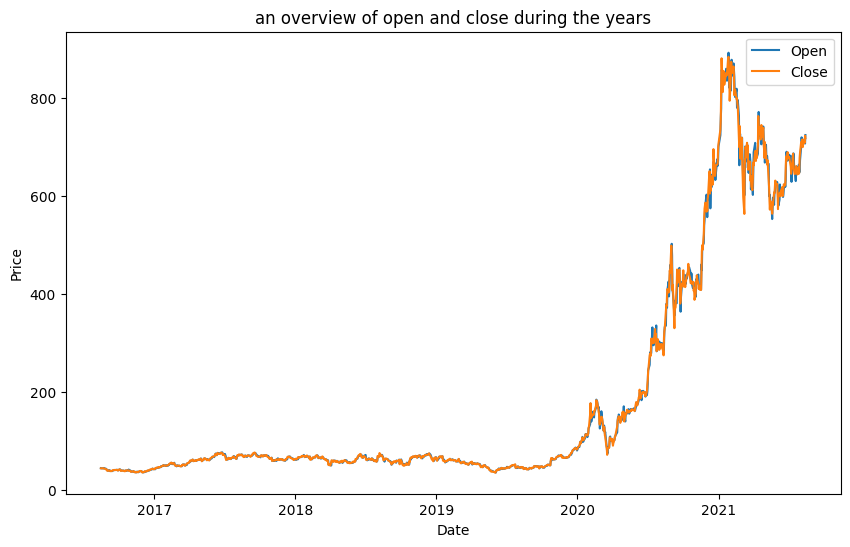

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Open'], label = 'Open')
plt.plot(df['Date'], df['Close'], label = 'Close')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title('an overview of open and close during the years')
plt.legend()
plt.show()

**Closing Price:**
The closing price is the last price at which the stock is traded during the regular trading day. A stock's closing price is the standard benchmark used by investors to track its performance over time.

In [5]:
#We dont want the dates so we remove them
tesla_close = df[['Close']]
tesla_close

,Close
0,44.722000
1,44.647999
2,44.702000
3,45.000000
4,44.585999
...,...
1253,713.760010
1254,709.989990
1255,707.820007
1256,722.250000


In [6]:
training_set = tesla_close.values
training_set.shape

(1258, 1)

In [7]:
def window(data, seq_l):
  x = []
  y = []
  n = len(data)

  for i in range(n - seq_l -1):
    start_x = i
    end_x = i+ seq_l
    x_i = data[start_x : end_x]
    y_i = data[end_x]

    x.append(x_i)
    y.append(y_i)

  return np.array(x), np.array(y)


we nomralize dataset so that it would be in range [0,1].

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
training_data = scaler.fit_transform(training_set)

In [9]:
seq_l = 20
x, y = window(training_data, seq_l)

In [10]:
print(x.shape)
print(y.shape)

(1237, 20, 1)
(1237, 1)


In [11]:
x[0]

array([[0.01053705],
       [0.01044971],
       [0.01051345],
       [0.01086515],
       [0.01037654],
       [0.01082738],
       [0.01030336],
       [0.00991153],
       [0.00968257],
       [0.00855191],
       [0.00764078],
       [0.00779893],
       [0.00514578],
       [0.00444001],
       [0.00563204],
       [0.00536766],
       [0.00434087],
       [0.0036587 ],
       [0.00456275],
       [0.00403165]])

train test split

In [12]:
train_size = int(len(y)* 0.8)
test_size = len(y)- train_size

from torch.autograd import Variable

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

LSTM

In [ ]:
import torch.nn as nn

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_l
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # init hidden state
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # init cell state
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [ ]:
num_epochs = 100
learning_rate = 0.01
input_size = 1
hidden_size = 16
num_layers = 1
num_classes = 1

In [ ]:
model_lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

In [ ]:
train_losses = []
model_lstm.train()
hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    outputs = model_lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    train_losses.append(loss.item())
    hist[epoch] = loss.item()
    
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, {loss.item()}")

Epoch: 0, 0.00973727647215128
Epoch: 10, 0.0039453404024243355
Epoch: 20, 0.0026779486797749996
Epoch: 30, 0.0016205039573833346
Epoch: 40, 0.0005665836506523192
Epoch: 50, 0.00020281161414459348
Epoch: 60, 8.579101995564997e-05
Epoch: 70, 6.694031617371365e-05
Epoch: 80, 6.411824870156124e-05
Epoch: 90, 6.330010364763439e-05


In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(outputs.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(trainY.detach().numpy()))

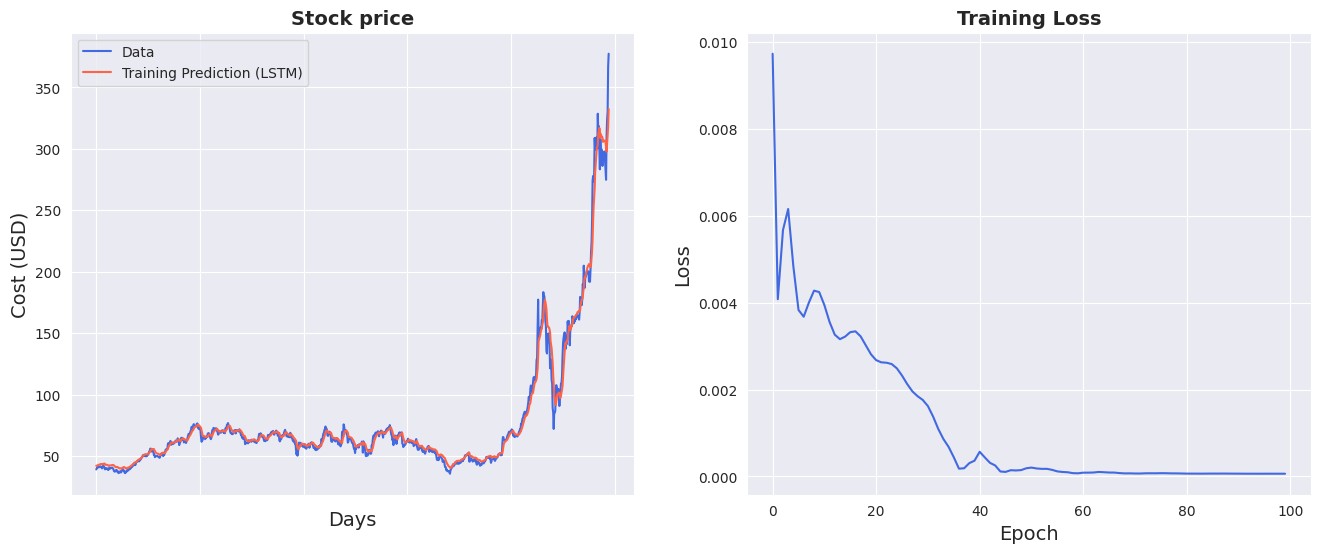

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

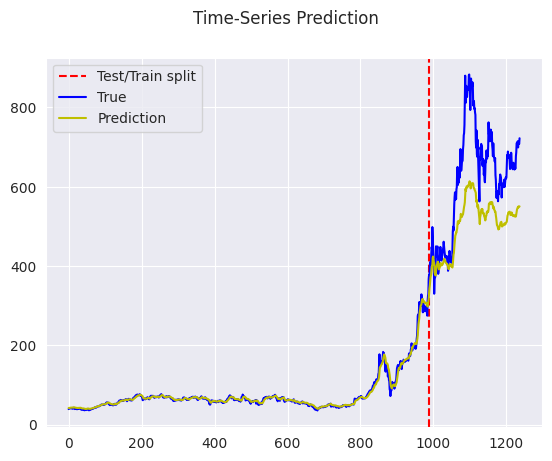

In [ ]:
model_lstm.eval()
train_predict = model_lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, color='b')
plt.plot(data_predict, color='y')
plt.legend(["Test/Train split", "True", "Prediction"], loc ="upper left")

plt.suptitle('Time-Series Prediction')
plt.show()

Evaluate the performance of the model on the test dataset. Useing appropriate metrics such as MAE, MSE, or R2 score.

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

test_predict = model_lstm(testX)
test_predict = test_predict.detach().numpy()
test_predict = scaler.inverse_transform(test_predict)
original_ytest = scaler.inverse_transform(testY.reshape(-1,1)) 

print("LSTM: Test data MSE: ",mean_squared_error(original_ytest,test_predict))
print("LSTM: Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("LSTM: Test data r2_score: ", r2_score(original_ytest,test_predict))


LSTM: Test data MSE:  18107.54941500056
LSTM: Test data MAE:  115.66102601660796
LSTM: Test data r2_score:  0.025660099630167132


In [ ]:
num_epochs = 100
learning_rate = 0.01

input_size = 1
hidden_size = 32
num_layers = 1

num_classes = 1

model_lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

train_losses = []
model_lstm.train()
hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    outputs = model_lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    train_losses.append(loss.item())
    hist[epoch] = loss.item()
    
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, {loss.item()}")

Epoch: 0, 0.006686497014015913
Epoch: 10, 0.0032886341214179993
Epoch: 20, 0.0003779734834097326
Epoch: 30, 0.00029276416171342134
Epoch: 40, 0.00010582179675111547
Epoch: 50, 7.19903182471171e-05
Epoch: 60, 5.27140982740093e-05
Epoch: 70, 5.242863699095324e-05
Epoch: 80, 5.0404367357259616e-05
Epoch: 90, 4.953042298438959e-05


In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(outputs.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(trainY.detach().numpy()))

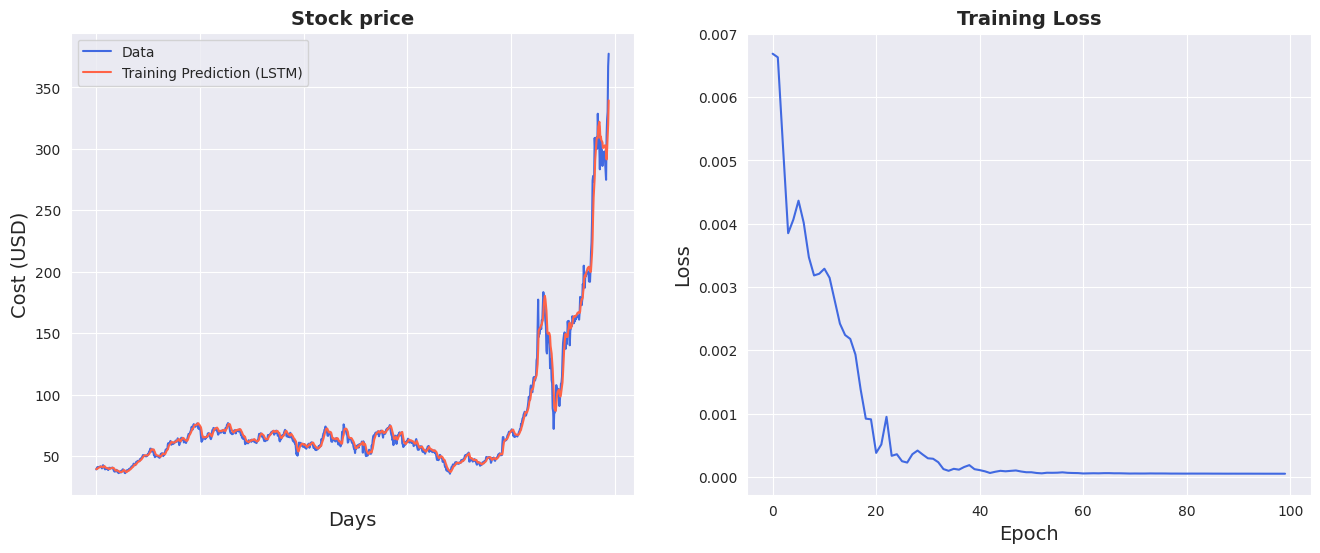

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

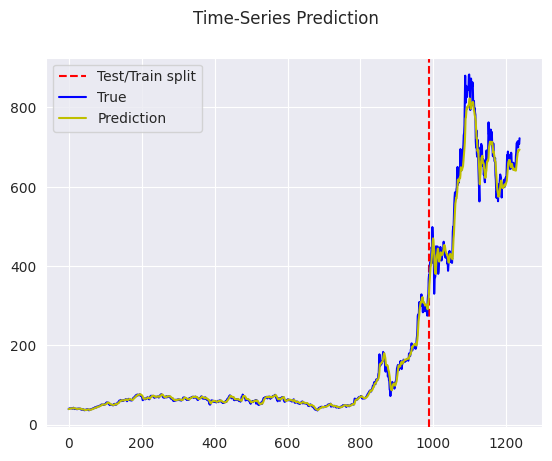

In [ ]:
model_lstm.eval()
train_predict = model_lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, color='b')
plt.plot(data_predict, color='y')
plt.legend(["Test/Train split", "True", "Prediction"], loc ="upper left")

plt.suptitle('Time-Series Prediction')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

test_predict = model_lstm(testX)
test_predict = test_predict.detach().numpy()
test_predict = scaler.inverse_transform(test_predict)
original_ytest = scaler.inverse_transform(testY.reshape(-1,1)) 

print("LSTM: Test data MSE: ",mean_squared_error(original_ytest,test_predict))
print("LSTM: Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("LSTM: Test data r2_score: ", r2_score(original_ytest,test_predict))


LSTM: Test data MSE:  1084.1325573624947
LSTM: Test data MAE:  25.22262516439338
LSTM: Test data r2_score:  0.9416644636047107


GRU

In [14]:
import torch.nn as nn
class GRU(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(GRU, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
       
        
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        
        ula, h_out = self.gru(x, h_0)

        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [15]:
num_epochs = 100
learning_rate = 0.01
input_size = 1
hidden_size = 16
num_layers = 1
num_classes = 1


model_gru = GRU(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_gru.parameters(), lr=learning_rate)

train_losses = []
model_gru.train()
hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    outputs = model_gru(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    train_losses.append(loss.item())
    hist[epoch] = loss.item()
    
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, {loss.item()}")

Epoch: 0, 0.0053146653808653355
Epoch: 10, 0.002408403204753995
Epoch: 20, 0.0005321362987160683
Epoch: 30, 0.00014305752119980752
Epoch: 40, 4.817328954231925e-05
Epoch: 50, 5.297602547216229e-05
Epoch: 60, 3.440542423049919e-05
Epoch: 70, 3.388717959751375e-05
Epoch: 80, 3.053744512726553e-05
Epoch: 90, 3.0609211535193026e-05


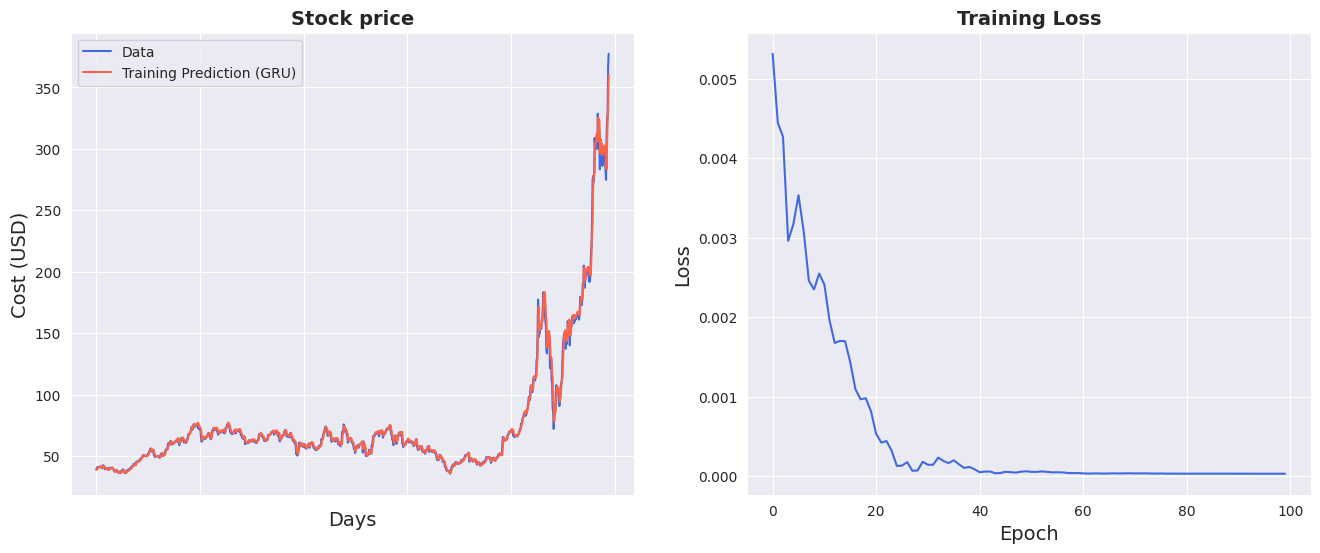

In [16]:
predict = pd.DataFrame(scaler.inverse_transform(outputs.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(trainY.detach().numpy()))

import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

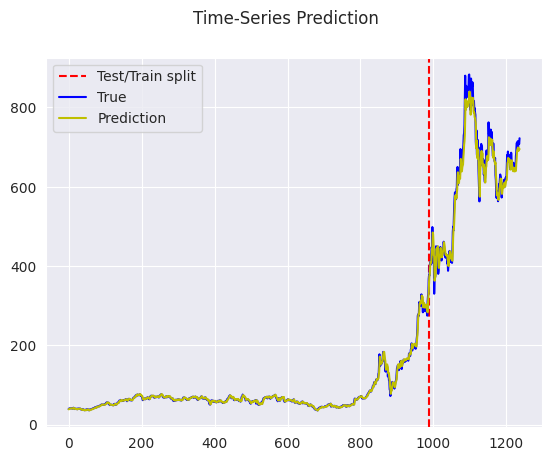

In [17]:
model_gru.eval()
train_predict = model_gru(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, color='b')
plt.plot(data_predict, color='y')
plt.legend(["Test/Train split", "True", "Prediction"], loc ="upper left")

plt.suptitle('Time-Series Prediction')
plt.show()

In [19]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

test_predict = model_gru(testX)
test_predict = test_predict.detach().numpy()
test_predict = scaler.inverse_transform(test_predict)
original_ytest = scaler.inverse_transform(testY.reshape(-1,1)) 

print("GRU: Test data MSE: ",mean_squared_error(original_ytest,test_predict))
print("GRU: Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("GRU: Test data r2_score: ", r2_score(original_ytest,test_predict))


GRU: Test data MSE:  744.584494848108
GRU: Test data MAE:  20.47324799493378
GRU: Test data r2_score:  0.9599350322950807


In [20]:
num_epochs = 100
learning_rate = 0.01
input_size = 1
hidden_size = 32
num_layers = 1
num_classes = 1

model_gru = GRU(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_gru.parameters(), lr=learning_rate)

train_losses = []
model_gru.train()
hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    outputs = model_gru(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    train_losses.append(loss.item())
    hist[epoch] = loss.item()
    
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, {loss.item()}")

Epoch: 0, 0.005000925622880459
Epoch: 10, 0.004305132199078798
Epoch: 20, 0.0013329064240679145
Epoch: 30, 0.00010525868128752336
Epoch: 40, 0.00019913361757062376
Epoch: 50, 7.482517685275525e-05
Epoch: 60, 4.822916889679618e-05
Epoch: 70, 3.3110514777945355e-05
Epoch: 80, 3.174955054419115e-05
Epoch: 90, 3.1182811653707176e-05


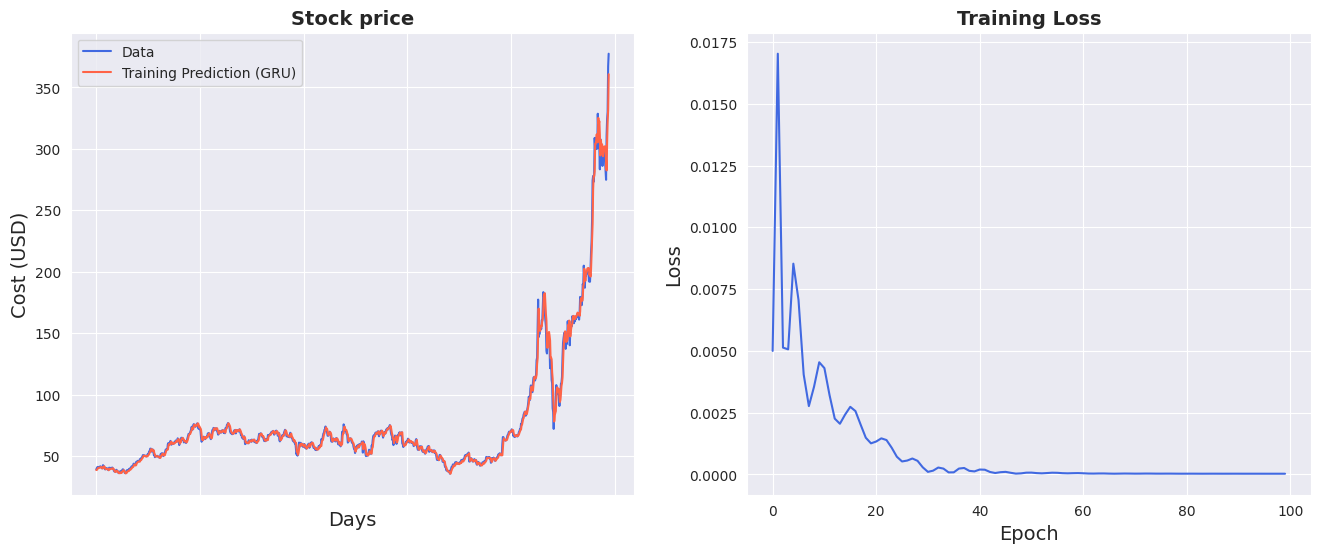

In [21]:
predict = pd.DataFrame(scaler.inverse_transform(outputs.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(trainY.detach().numpy()))

import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

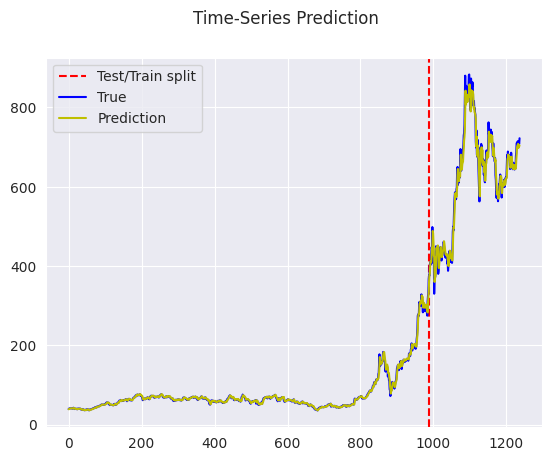

In [22]:
model_gru.eval()
train_predict = model_gru(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, color='b')
plt.plot(data_predict, color='y')
plt.legend(["Test/Train split", "True", "Prediction"], loc ="upper left")

plt.suptitle('Time-Series Prediction')
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

test_predict = model_gru(testX)
test_predict = test_predict.detach().numpy()
test_predict = scaler.inverse_transform(test_predict)
original_ytest = scaler.inverse_transform(testY.reshape(-1,1)) 

print("GRU: Test data MSE: ",mean_squared_error(original_ytest,test_predict))
print("GRU: Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("GRU: Test data r2_score: ", r2_score(original_ytest,test_predict))


GRU: Test data MSE:  599.123798762559
GRU: Test data MAE:  18.149192174424723
GRU: Test data r2_score:  0.9677620527760692


**multivariate**

In [49]:
tesla_df = pd.read_csv(io.BytesIO(uploaded['TSLA.csv']), index_col='Date', parse_dates=['Date'])
tesla_df = tesla_df[['Open', 'High', 'Low', 'Volume', 'Close']]

In [50]:
tesla_df.head()

,Open,High,Low,Volume,Close
Date,,,,,
2016-08-16,45.098000,45.438000,44.681999,11335500,44.722000
2016-08-17,44.866001,44.966000,44.560001,8935500,44.647999
2016-08-18,44.764000,45.132000,44.458000,8572500,44.702000
2016-08-19,44.708000,45.034000,44.506001,8297500,45.000000
2016-08-22,44.834000,45.021999,44.535999,10327500,44.585999


In [51]:
tesla_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2016-08-16 to 2021-08-13
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Volume  1258 non-null   int64  
 4   Close   1258 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 59.0 KB


In [52]:
def load_data(df, seq_len, out_feature=5, train_ratio=0.8, is_test=False):
    scaler = StandardScaler()
    scaler.fit(df)

    train_norm = scaler.transform(df)
    data = []
    for index in range(len(train_norm) - seq_len):
        data.append(train_norm[index:index + seq_len])

    data = np.array(data)

    train_len = len(data) if is_test else int(train_ratio * len(data))

    # train_x are sequences of seq_len-1 days. Features of each day are OPEN, CLOSE, HIGH, LOW, VOLUME
    # train_y is CLOSE price of day seq_len
    # shape is (n_data, n_sequence, features)
    train_x = data[:train_len, :-1, :]
    train_y = data[:train_len, -1, -out_feature:]

    test_x = data[train_len:, :-1, :]
    test_y = data[train_len:, -1, -out_feature:]

    return train_x, train_y, test_x, test_y

In [53]:
from sklearn.preprocessing import StandardScaler
seq_len = 20
batch_size = 128
n_epoch = 100
n_feature = 5
out_feature = 1

train_df = tesla_df.loc[:'2018']
test_df = tesla_df.loc['2019':]

train_x, train_y, test_x, test_y = load_data(train_df, seq_len, out_feature=out_feature)

In [43]:
train_x = torch.from_numpy(train_x).float().cuda()
train_y = torch.from_numpy(train_y).float().cuda()
test_x = torch.from_numpy(test_x).float().cuda()
test_y = torch.from_numpy(test_y).float().cuda()

train = torch.utils.data.TensorDataset(train_x, train_y)
test = torch.utils.data.TensorDataset(test_x, test_y)

train_loader = torch.utils.data.DataLoader(dataset=train,
                                               batch_size=batch_size,
                                               shuffle=True, drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=test,
                                             batch_size=1,
                                             shuffle=False)

In [44]:
import torch.nn as nn

class MultiRNN(nn.Module):

    def __init__(self, n_feature=5, out_feature=5, n_hidden=16, n_layers=2, drop_prob=0.5):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_feature = n_feature

        self.lstm = nn.LSTM(self.n_feature, self.n_hidden, self.n_layers, dropout=self.drop_prob, batch_first=True)

        self.dropout = nn.Dropout(drop_prob)

        self.fc = nn.Linear(n_hidden, out_feature)
        

    def forward(self, x, hidden):
        
        l_out, l_hidden = self.lstm(x, hidden)
        out = self.dropout(l_out)
        out = self.fc(out[:, -1, :])

        return out, l_hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        

        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        return hidden


In [45]:
net = MultiRNN(n_feature=n_feature, out_feature=out_feature)
net.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())
test_loss_list = []

End of Epoch  0 test loss:  0.12373567434029799
End of Epoch  1 test loss:  0.12318815057495094
End of Epoch  2 test loss:  0.12270546851189873
End of Epoch  3 test loss:  0.12257431671411492
End of Epoch  4 test loss:  0.12224603125145975
End of Epoch  5 test loss:  0.12207997094373602
End of Epoch  6 test loss:  0.12177248280021194
End of Epoch  7 test loss:  0.12126761318731481
End of Epoch  8 test loss:  0.12180164928909577
End of Epoch  9 test loss:  0.12123850197241186
End of Epoch  10 test loss:  0.12012289863541183
End of Epoch  11 test loss:  0.11904837278331899
End of Epoch  12 test loss:  0.11788261083491872
End of Epoch  13 test loss:  0.11785440064560479
End of Epoch  14 test loss:  0.1189020874977077
End of Epoch  15 test loss:  0.11964318752164468
End of Epoch  16 test loss:  0.11936743731228436
End of Epoch  17 test loss:  0.11872854430997246
End of Epoch  18 test loss:  0.11832968858865225
End of Epoch  19 test loss:  0.11737368806242213
End of Epoch  20 test loss:  0.

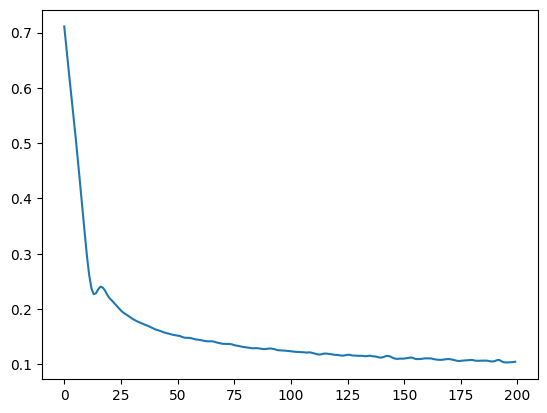

In [47]:
for epoch in range(n_epoch):

    for i, (x, y) in enumerate(train_loader):
        output, hidden = net(x, net.init_hidden(batch_size))
        loss = criterion(output, y)

        net.zero_grad()
        loss.backward()
        optimizer.step()

    net.eval()
    test_loss_sum = 0
    for i, (x, y) in enumerate(test_loader):
        with torch.no_grad():
            output, hidden = net(x, net.init_hidden(1))
            val_loss = criterion(output, y)
            test_loss_sum += val_loss.item()
            

    test_loss_list.append(test_loss_sum/len(test_loader))
    print('End of Epoch ', epoch, 'test loss: ', test_loss_sum/len(test_loader))
    net.train()
    
plt.plot(test_loss_list)

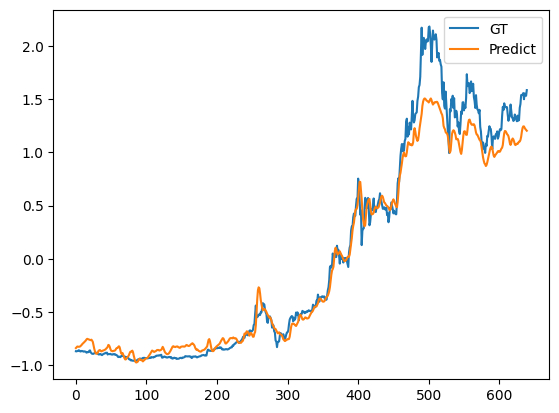

In [48]:
# test_df.shape
test_x, test_y, _, _ = load_data(test_df, seq_len, out_feature=out_feature, is_test=True)

test_x = torch.from_numpy(test_x).float().cuda()
test_y = torch.from_numpy(test_y).float().cuda()

test = torch.utils.data.TensorDataset(test_x, test_y)

test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=1, shuffle=False)

net.eval()
test_predict = []
for i, (x, y) in enumerate(test_loader):
  
    with torch.no_grad():
        output, hidden = net(x, net.init_hidden(1))
    test_predict.append(output[:, -1])
    test_predict_tensor = torch.cat(test_predict, dim=0)

plt.plot(test_y[:, -1].cpu().numpy(), label='GT')
plt.plot(test_predict_tensor.cpu().numpy(), label='Predict')
plt.legend()